Found 18 object connectivity matrices
Found 18 scramble connectivity matrices
Created difference matrices for 18 subjects


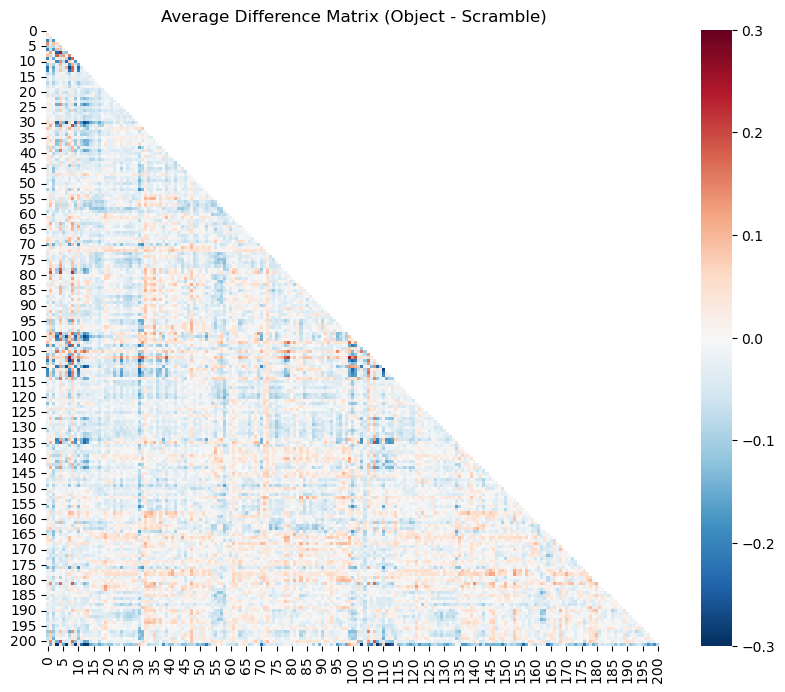

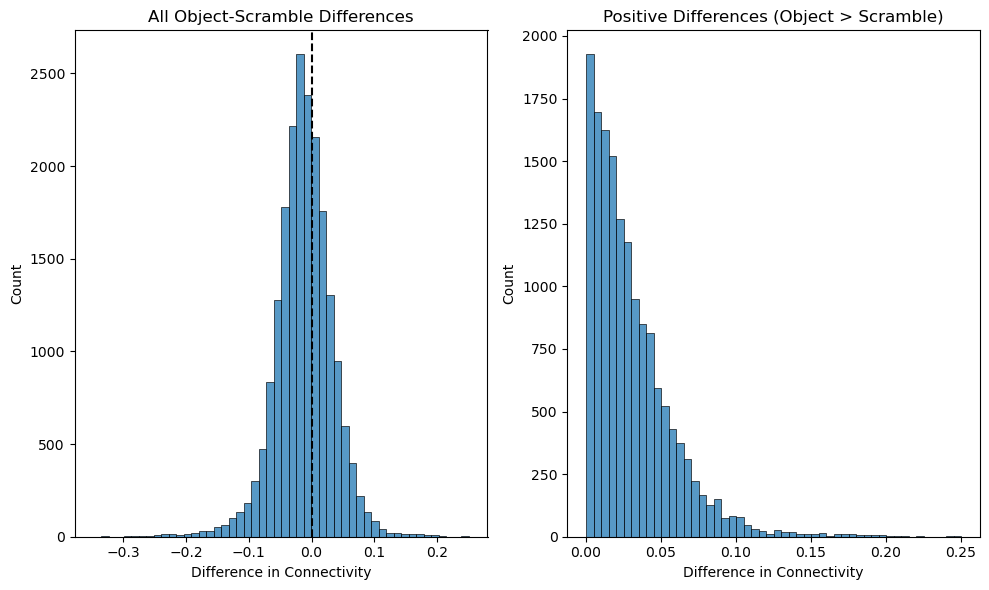

Subject sub-095: Using largest component (200 nodes) for path length
Subject sub-038: Using largest component (201 nodes) for path length
Subject sub-087: Using largest component (198 nodes) for path length
Subject sub-096: Using largest component (194 nodes) for path length
Subject sub-064: Using largest component (201 nodes) for path length
Subject sub-107: Using largest component (201 nodes) for path length
Subject sub-067: Using largest component (193 nodes) for path length
Subject sub-085: Using largest component (201 nodes) for path length
Subject sub-059: Using largest component (198 nodes) for path length
Subject sub-068: Using largest component (201 nodes) for path length
Subject sub-097: Using largest component (201 nodes) for path length
Subject sub-083: Using largest component (195 nodes) for path length

Network Metrics (From Tutorial):
Average Density: 0.143 ± 0.031
Average Path Length: 9.463 ± 4.099
Average Clustering Coefficient: 0.086 ± 0.025


<Figure size 1500x500 with 0 Axes>

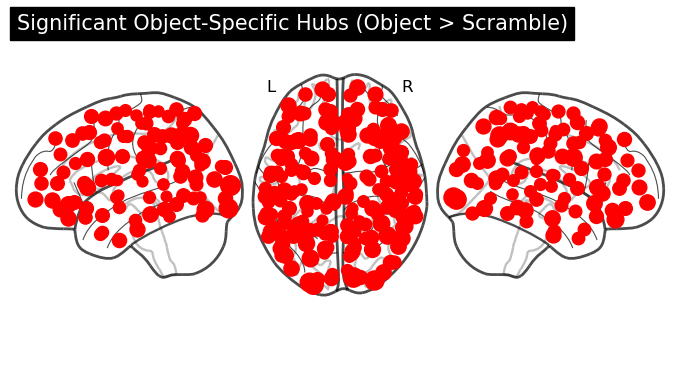


Top Object-Specific Hubs (Object > Scramble):
ROI 8: 7Networks_LH_Vis_9
  Mean Hub Score: 0.148
  T-statistic: 6.020
  P-value: 0.000014

ROI 105: 7Networks_RH_Vis_6
  Mean Hub Score: 0.143
  T-statistic: 5.402
  P-value: 0.000048

ROI 107: 7Networks_RH_Vis_8
  Mean Hub Score: 0.140
  T-statistic: 7.947
  P-value: 0.000000

ROI 4: 7Networks_LH_Vis_5
  Mean Hub Score: 0.133
  T-statistic: 6.083
  P-value: 0.000012

ROI 178: 7Networks_RH_Cont_Cing_2
  Mean Hub Score: 0.116
  T-statistic: 4.666
  P-value: 0.000221

ROI 166: 7Networks_RH_Cont_Par_3
  Mean Hub Score: 0.113
  T-statistic: 5.767
  P-value: 0.000023

ROI 158: 7Networks_RH_Limbic_OFC_1
  Mean Hub Score: 0.108
  T-statistic: 3.339
  P-value: 0.003889

ROI 1: 7Networks_LH_Vis_2
  Mean Hub Score: 0.105
  T-statistic: 5.685
  P-value: 0.000027

ROI 140: 7Networks_RH_DorsAttn_Post_7
  Mean Hub Score: 0.104
  T-statistic: 5.809
  P-value: 0.000021

ROI 72: 7Networks_LH_Cont_Cing_2
  Mean Hub Score: 0.099
  T-statistic: 4.620
  P-val

In [ ]:
# Network Theory without Correction [object>scramble]
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import os
import networkx as nx
import community
import nibabel as nib
from nilearn import datasets, plotting
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

# Set up paths
curr_dir = '/user_data/csimmon2/git_repos/ptoc'
results_dir = f'{curr_dir}/results'
merged_atlas_path = f'{results_dir}/schaefer_wang_merged.nii.gz'
merged_labels_path = f'{results_dir}/merged_atlas_labels.npy'

# Load merged atlas labels
def load_merged_atlas():
    """Load the merged Schaefer+Wang atlas"""
    if os.path.exists(merged_atlas_path) and os.path.exists(merged_labels_path):
        atlas_img = nib.load(merged_atlas_path)
        labels = np.load(merged_labels_path, allow_pickle=True)
        return atlas_img, labels
    else:
        print("Merged atlas files not found. Using standard Schaefer atlas.")
        atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200)
        return nib.load(atlas.maps), atlas.labels

# Load subject matrices
def load_subject_matrices(results_dir, condition):
    """Load connectivity matrices using merged atlas"""
    matrix_dir = f'{results_dir}/connectivity_merged_{condition.lower()}'
    matrix_files = glob.glob(f'{matrix_dir}/*.npy')
    
    if not matrix_files:
        raise FileNotFoundError(f"No {condition} connectivity matrices found in {matrix_dir}")
    
    print(f"Found {len(matrix_files)} {condition} connectivity matrices")
    subjects = [os.path.basename(f).split('_')[0] for f in matrix_files]
    matrices = {sub: np.load(file) for sub, file in zip(subjects, matrix_files)}
    
    return matrices

# Create subject-level difference matrices
def create_difference_matrices(object_matrices, scramble_matrices):
    """Create difference matrices (object - scramble) for each subject"""
    diff_matrices = {}
    
    # Find subjects with data in both conditions
    common_subjects = set(object_matrices.keys()) & set(scramble_matrices.keys())
    
    for sub in common_subjects:
        diff_matrices[sub] = object_matrices[sub] - scramble_matrices[sub]
    
    print(f"Created difference matrices for {len(diff_matrices)} subjects")
    return diff_matrices

# Compute network metrics for subject-level matrices
def compute_graph_metrics(matrices):
    """Compute graph theory metrics for a set of matrices"""
    results = {}
    
    for sub, matrix in matrices.items():
        try:
            # Keep only positive values (object > scramble)
            pos_matrix = matrix.copy()
            pos_matrix[pos_matrix < 0] = 0
            
            # Threshold at mean + std
            threshold = np.mean(pos_matrix) + np.std(pos_matrix)
            matrix_thresh = pos_matrix.copy()
            matrix_thresh[matrix_thresh < threshold] = 0
            
            # Create graph
            G = nx.from_numpy_array(matrix_thresh)
            G.remove_edges_from(nx.selfloop_edges(G))
            
            # Skip if graph is empty
            if G.number_of_edges() == 0:
                print(f"Skipping subject {sub}: no edges after thresholding")
                continue
                
            # Add distance attribute (inverse of weights)
            for u, v, d in G.edges(data=True):
                weight = abs(d['weight']) + 1e-6
                d['distance'] = 1.0 / weight
            
            # Compute metrics
            metrics = {
                # Network density (from tutorial)
                'density': nx.density(G),
                
                # Clustering coefficient (from tutorial)
                'clustering': nx.average_clustering(G, weight='weight'),
                
                # Centrality measures
                'degree': nx.degree_centrality(G),
                'betweenness': nx.betweenness_centrality(G, weight='distance'),
                'eigenvector': nx.eigenvector_centrality_numpy(G)
            }
            
            # Path length metrics if connected
            if nx.is_connected(G):
                metrics['avg_path_length'] = nx.average_shortest_path_length(G, weight='distance')
            else:
                # Get largest connected component
                largest_cc = max(nx.connected_components(G), key=len)
                G_cc = G.subgraph(largest_cc)
                metrics['avg_path_length'] = nx.average_shortest_path_length(G_cc, weight='distance')
                print(f"Subject {sub}: Using largest component ({len(largest_cc)} nodes) for path length")
            
            # Modularity
            metrics['communities'] = community.best_partition(G, weight='weight')
            
            # Calculate hub score
            hub_scores = {}
            for node in G.nodes():
                hub_scores[node] = (metrics['degree'][node] + 
                                  metrics['betweenness'][node] + 
                                  metrics['eigenvector'][node]) / 3
            
            metrics['hub_score'] = hub_scores
            results[sub] = metrics
            
        except Exception as e:
            print(f"Error processing subject {sub}: {e}")
    
    return results

# Statistical testing across subjects
def test_hub_significance(metrics_dict, atlas_labels, alpha=0.05):
    """Test which ROIs show significant hub scores"""
    # Extract hub scores for all subjects
    hub_scores = {}
    n_rois = len(atlas_labels)
    
    for roi in range(n_rois):
        hub_scores[roi] = []
    
    for sub, metrics in metrics_dict.items():
        for roi, score in metrics['hub_score'].items():
            hub_scores[roi].append(score)
    
    # One-sample t-test against zero
    significant_hubs = {}
    for roi, scores in hub_scores.items():
        if len(scores) >= 5:  # Require at least 5 subjects
            t_stat, p_val = stats.ttest_1samp(scores, 0)
            if p_val < alpha and t_stat > 0:  # Only positive hubs
                significant_hubs[roi] = {
                    'p_value': p_val,
                    't_statistic': t_stat,
                    'mean_score': np.mean(scores),
                    'name': atlas_labels[roi] if roi < len(atlas_labels) else f"ROI_{roi}"
                }
    
    return significant_hubs

# Visualize hub regions
def visualize_hubs(significant_hubs, atlas_img, atlas_labels):
    """Visualize significant hub regions on glass brain"""
    # Get coordinates
    coords = plotting.find_parcellation_cut_coords(atlas_img)
    
    # Get hub indices and scores
    hub_indices = list(significant_hubs.keys())
    hub_scores = [hub['mean_score'] for hub in significant_hubs.values()]
    
    # Create scaled sizes based on hub scores
    min_size = 50
    max_size = 200
    sizes = [(score - min(hub_scores)) / (max(hub_scores) - min(hub_scores)) * 
            (max_size - min_size) + min_size for score in hub_scores]
    
    # Plot on glass brain
    plt.figure(figsize=(15, 5))
    display = plotting.plot_glass_brain(None, display_mode='lzr',
                                      title='Significant Object-Specific Hubs (Object > Scramble)')
    
    for idx, roi in enumerate(hub_indices):
        if roi < len(coords):
            display.add_markers([coords[roi]], marker_color='red', marker_size=sizes[idx])
    
    plt.show()
    
    # Print hub details
    print("\nTop Object-Specific Hubs (Object > Scramble):")
    print("=========================================")
    for roi, hub in sorted(significant_hubs.items(), key=lambda x: x[1]['mean_score'], reverse=True)[:10]:
        print(f"ROI {roi}: {hub['name']}")
        print(f"  Mean Hub Score: {hub['mean_score']:.3f}")
        print(f"  T-statistic: {hub['t_statistic']:.3f}")
        print(f"  P-value: {hub['p_value']:.6f}")
        print()

# Run full analysis
def run_full_analysis():
    """Run complete network analysis on object > scramble"""
    # Load atlas
    atlas_img, atlas_labels = load_merged_atlas()
    
    # Load matrices
    object_matrices = load_subject_matrices(results_dir, 'object')
    scramble_matrices = load_subject_matrices(results_dir, 'scramble')
    
    # Create difference matrices
    diff_matrices = create_difference_matrices(object_matrices, scramble_matrices)
    
    # Calculate average difference matrix
    avg_diff = np.mean([m for m in diff_matrices.values()], axis=0)
    
    # Visualize average difference matrix
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(avg_diff, dtype=bool))
    sns.heatmap(avg_diff, 
                mask=mask,
                cmap='RdBu_r',
                center=0,
                square=True,
                vmin=-0.3,
                vmax=0.3)
    plt.title('Average Difference Matrix (Object - Scramble)')
    plt.show()
    
    # Create positive difference matrix (object > scramble)
    pos_avg_diff = avg_diff.copy()
    pos_avg_diff[pos_avg_diff < 0] = 0
    
    # Histogram of connectivity differences
    plt.figure(figsize=(10, 6))
    plt.subplot(121)
    sns.histplot(avg_diff[~mask], bins=50)
    plt.axvline(x=0, color='k', linestyle='--')
    plt.title('All Object-Scramble Differences')
    plt.xlabel('Difference in Connectivity')
    
    plt.subplot(122)
    sns.histplot(pos_avg_diff[pos_avg_diff > 0], bins=50)
    plt.title('Positive Differences (Object > Scramble)')
    plt.xlabel('Difference in Connectivity')
    plt.tight_layout()
    plt.show()
    
    # Compute network metrics on subject-level difference matrices
    diff_metrics = compute_graph_metrics(diff_matrices)
    
    # Calculate and display average network metrics
    densities = [m['density'] for m in diff_metrics.values() if 'density' in m]
    path_lengths = [m['avg_path_length'] for m in diff_metrics.values() 
                   if 'avg_path_length' in m]
    clusterings = [m['clustering'] for m in diff_metrics.values() if 'clustering' in m]
    
    print("\nNetwork Metrics (From Tutorial):")
    print("=============================")
    print(f"Average Density: {np.mean(densities):.3f} ± {np.std(densities):.3f}")
    print(f"Average Path Length: {np.mean(path_lengths):.3f} ± {np.std(path_lengths):.3f}")
    print(f"Average Clustering Coefficient: {np.mean(clusterings):.3f} ± {np.std(clusterings):.3f}")
    
    # Find significant hubs
    significant_hubs = test_hub_significance(diff_metrics, atlas_labels)
    
    # Visualize significant hubs
    visualize_hubs(significant_hubs, atlas_img, atlas_labels)
    
    return diff_matrices, diff_metrics, significant_hubs, avg_diff

# Run the full analysis
diff_matrices, diff_metrics, significant_hubs, avg_diff = run_full_analysis()

Found 44 significant hubs after FDR correction

Top Object-Specific Hubs:
ROI 8: 7Networks_LH_Vis_9
  Hub Score: 0.149 (proportion of significant connections)
  Mean T-statistic: 3.955
  Min corrected p-value: 0.007695

ROI 107: 7Networks_RH_Vis_8
  Hub Score: 0.134 (proportion of significant connections)
  Mean T-statistic: 4.729
  Min corrected p-value: 0.000192

ROI 4: 7Networks_LH_Vis_5
  Hub Score: 0.095 (proportion of significant connections)
  Mean T-statistic: 3.966
  Min corrected p-value: 0.010395

ROI 105: 7Networks_RH_Vis_6
  Hub Score: 0.075 (proportion of significant connections)
  Mean T-statistic: 4.351
  Min corrected p-value: 0.007236

ROI 99: 7Networks_LH_Default_PHC_1
  Hub Score: 0.050 (proportion of significant connections)
  Mean T-statistic: 5.062
  Min corrected p-value: 0.000960

ROI 79: 7Networks_LH_Default_Par_2
  Hub Score: 0.030 (proportion of significant connections)
  Mean T-statistic: 4.460
  Min corrected p-value: 0.011400

ROI 30: 7Networks_LH_DorsAtt

<Figure size 1500x500 with 0 Axes>

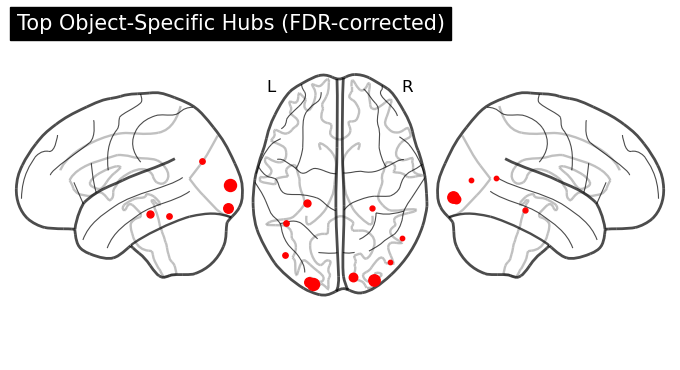

<Figure size 1500x500 with 0 Axes>

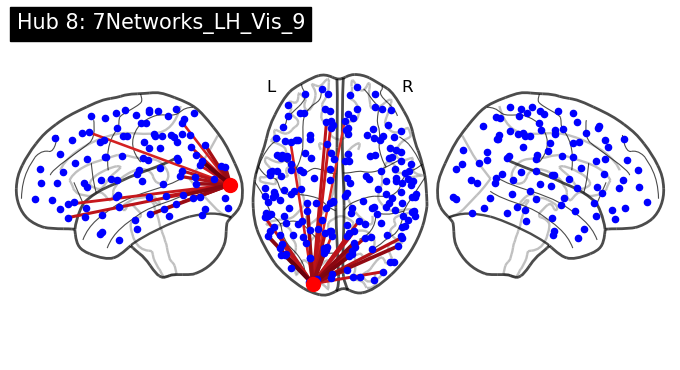


Hub 8 (7Networks_LH_Vis_9) significant connections:
- 7Networks_LH_Vis_4 (t = 4.203, p = 0.010056)
- 7Networks_LH_Vis_6 (t = 3.483, p = 0.024995)
- 7Networks_LH_Vis_10 (t = 3.501, p = 0.024995)
- 7Networks_LH_Vis_12 (t = 3.033, p = 0.047405)
- 7Networks_LH_Vis_13 (t = 3.600, p = 0.022318)
- 7Networks_LH_Vis_14 (t = 3.258, p = 0.032250)
- 7Networks_LH_DorsAttn_Post_2 (t = 5.377, p = 0.007733)
- 7Networks_LH_DorsAttn_Post_9 (t = 3.276, p = 0.032126)
- 7Networks_LH_Limbic_OFC_2 (t = 4.878, p = 0.007733)
- 7Networks_LH_Cont_Temp_1 (t = 4.158, p = 0.010246)
- 7Networks_LH_Default_Par_1 (t = 3.456, p = 0.025007)
- 7Networks_LH_Default_Par_2 (t = 4.546, p = 0.007733)
- 7Networks_LH_Default_Par_4 (t = 3.119, p = 0.042028)
- 7Networks_LH_Default_PFC_2 (t = 3.550, p = 0.023694)
- 7Networks_LH_Default_PFC_11 (t = 3.939, p = 0.013085)
- 7Networks_LH_Default_pCunPCC_1 (t = 4.420, p = 0.008411)
- 7Networks_LH_Default_PHC_1 (t = 5.044, p = 0.007733)
- 7Networks_RH_Vis_4 (t = 4.593, p = 0.007733)
- 7

In [9]:
# Apply FDR correction to hub analysis
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import os
import networkx as nx
import community
import nibabel as nib
from nilearn import datasets, plotting
import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection
import warnings
warnings.filterwarnings('ignore')

# Set up paths
curr_dir = '/user_data/csimmon2/git_repos/ptoc'
results_dir = f'{curr_dir}/results'
merged_atlas_path = f'{results_dir}/schaefer_wang_merged.nii.gz'
merged_labels_path = f'{results_dir}/merged_atlas_labels.npy'

# Load merged atlas labels
def load_merged_atlas():
    """Load the merged Schaefer+Wang atlas"""
    if os.path.exists(merged_atlas_path) and os.path.exists(merged_labels_path):
        atlas_img = nib.load(merged_atlas_path)
        labels = np.load(merged_labels_path, allow_pickle=True)
        return atlas_img, labels
    else:
        print("Merged atlas files not found. Using standard Schaefer atlas.")
        atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200)
        return nib.load(atlas.maps), atlas.labels

# Load subject matrices
def load_subject_matrices(results_dir, condition):
    """Load connectivity matrices using merged atlas"""
    matrix_dir = f'{results_dir}/connectivity_merged_{condition.lower()}'
    matrix_files = glob.glob(f'{matrix_dir}/*.npy')
    
    if not matrix_files:
        raise FileNotFoundError(f"No {condition} connectivity matrices found in {matrix_dir}")
    
    print(f"Found {len(matrix_files)} {condition} connectivity matrices")
    subjects = [os.path.basename(f).split('_')[0] for f in matrix_files]
    matrices = {sub: np.load(file) for sub, file in zip(subjects, matrix_files)}
    
    return matrices

# FDR correction for hub analysis
def analyze_object_hubs_with_fdr(diff_matrices, atlas_labels, alpha=0.05):
    """Identify significant hubs with FDR correction"""
    # Get average difference matrix
    avg_diff = np.mean([m for m in diff_matrices.values()], axis=0)
    
    # Keep only positive differences (object > scramble)
    pos_diff = avg_diff.copy()
    pos_diff[pos_diff < 0] = 0
    
    # Compute t-statistics for each ROI
    t_stats = []
    p_values = []
    hub_scores = []
    
    for roi in range(pos_diff.shape[0]):
        # Get connectivity values for this ROI across subjects
        roi_values = [diff[roi, :] for diff in diff_matrices.values()]
        roi_values = np.array(roi_values)
        
        # Compute t-statistic for each connection
        t_roi = []
        p_roi = []
        
        for conn in range(pos_diff.shape[1]):
            if roi != conn:  # Skip self-connections
                t, p = stats.ttest_1samp(roi_values[:, conn], 0)
                t_roi.append(t)
                p_roi.append(p)
        
        # Apply FDR correction to connections
        if len(p_roi) > 0:
            significant, corrected_p = fdrcorrection(p_roi, alpha=alpha)
            
            # Count significant positive connections
            pos_t = np.array(t_roi) > 0
            sig_pos = significant & pos_t
            hub_score = np.sum(sig_pos) / len(p_roi)
            
            t_stats.append(np.mean(np.array(t_roi)[sig_pos]) if np.any(sig_pos) else 0)
            p_values.append(np.min(np.array(corrected_p)[sig_pos]) if np.any(sig_pos) else 1.0)
            hub_scores.append(hub_score)
        else:
            t_stats.append(0)
            p_values.append(1.0)
            hub_scores.append(0)
    
    # Create results dataframe
    results = pd.DataFrame({
        'ROI': range(len(hub_scores)),
        'Hub_Score': hub_scores,
        'Mean_T': t_stats,
        'Min_P': p_values,
        'Label': [atlas_labels[i] if i < len(atlas_labels) else f"ROI_{i}" for i in range(len(hub_scores))]
    })
    
    # Filter for significant hubs
    sig_hubs = results[results['Min_P'] < alpha].sort_values('Hub_Score', ascending=False)
    
    return sig_hubs, results

# Plot network for a specific hub
def plot_hub_network(hub_roi, diff_matrices, atlas_labels, atlas_img):
    """Create a network plot for a specific hub ROI"""
    # Get average difference matrix
    avg_diff = np.mean([m for m in diff_matrices.values()], axis=0)
    
    # Get coordinates for all ROIs
    coords = plotting.find_parcellation_cut_coords(atlas_img)
    
    # Get t-statistics for connections
    roi_values = [diff[hub_roi, :] for diff in diff_matrices.values()]
    roi_values = np.array(roi_values)
    
    t_stats = []
    p_values = []
    
    for conn in range(avg_diff.shape[1]):
        if hub_roi != conn:  # Skip self-connections
            t, p = stats.ttest_1samp(roi_values[:, conn], 0)
            t_stats.append(t)
            p_values.append(p)
        else:
            t_stats.append(0)
            p_values.append(1.0)
    
    # Apply FDR correction
    significant, corrected_p = fdrcorrection(p_values, alpha=0.05)
    
    # Keep only significant positive connections
    pos_t = np.array(t_stats) > 0
    sig_pos = significant & pos_t
    
    # Create connection matrix
    conn_matrix = np.zeros((avg_diff.shape[0], avg_diff.shape[0]))
    
    sig_indices = np.where(sig_pos)[0]
    for idx in sig_indices:
        conn_matrix[hub_roi, idx] = avg_diff[hub_roi, idx]
        conn_matrix[idx, hub_roi] = avg_diff[hub_roi, idx]
    
    # Plot the network
    hub_name = atlas_labels[hub_roi] if hub_roi < len(atlas_labels) else f"ROI_{hub_roi}"
    plt.figure(figsize=(15, 5))
    
    display = plotting.plot_connectome(
        conn_matrix, coords, 
        node_color="blue",
        node_size=20,
        edge_cmap='Reds',
        display_mode='lzr',
        title=f"Hub {hub_roi}: {hub_name}"
    )
    
    # Highlight hub node
    display.add_markers([coords[hub_roi]], marker_color='red', marker_size=100)
    plt.show()
    
    # Print connection information
    print(f"\nHub {hub_roi} ({hub_name}) significant connections:")
    for idx in sig_indices:
        target_name = atlas_labels[idx] if idx < len(atlas_labels) else f"ROI_{idx}"
        print(f"- {target_name} (t = {t_stats[idx]:.3f}, p = {corrected_p[idx]:.6f})")

# Run the FDR-corrected analysis (using previously loaded diff_matrices)
atlas_img, atlas_labels = load_merged_atlas()
sig_hubs, all_hub_results = analyze_object_hubs_with_fdr(diff_matrices, atlas_labels)

# Display top hubs
print(f"Found {len(sig_hubs)} significant hubs after FDR correction")
print("\nTop Object-Specific Hubs:")
print("====================")
for _, hub in sig_hubs.head(10).iterrows():
    print(f"ROI {int(hub['ROI'])}: {hub['Label']}")
    print(f"  Hub Score: {hub['Hub_Score']:.3f} (proportion of significant connections)")
    print(f"  Mean T-statistic: {hub['Mean_T']:.3f}")
    print(f"  Min corrected p-value: {hub['Min_P']:.6f}")
    print()

# Visualize top hubs on brain
plt.figure(figsize=(15, 5))
display = plotting.plot_glass_brain(None, display_mode='lzr',
                                  title='Top Object-Specific Hubs (FDR-corrected)')

# Get coordinates
coords = plotting.find_parcellation_cut_coords(atlas_img)

# Add markers for top 10 hubs or all if fewer
top_n = min(10, len(sig_hubs))
for _, hub in sig_hubs.head(top_n).iterrows():
    roi = int(hub['ROI'])
    if roi < len(coords):
        display.add_markers([coords[roi]], marker_color='red', 
                          marker_size=hub['Hub_Score']*500)  # Size by hub score
plt.show()

# Plot network for top hub
if len(sig_hubs) > 0:
    top_hub_roi = int(sig_hubs.iloc[0]['ROI'])
    plot_hub_network(top_hub_roi, diff_matrices, atlas_labels, atlas_img)

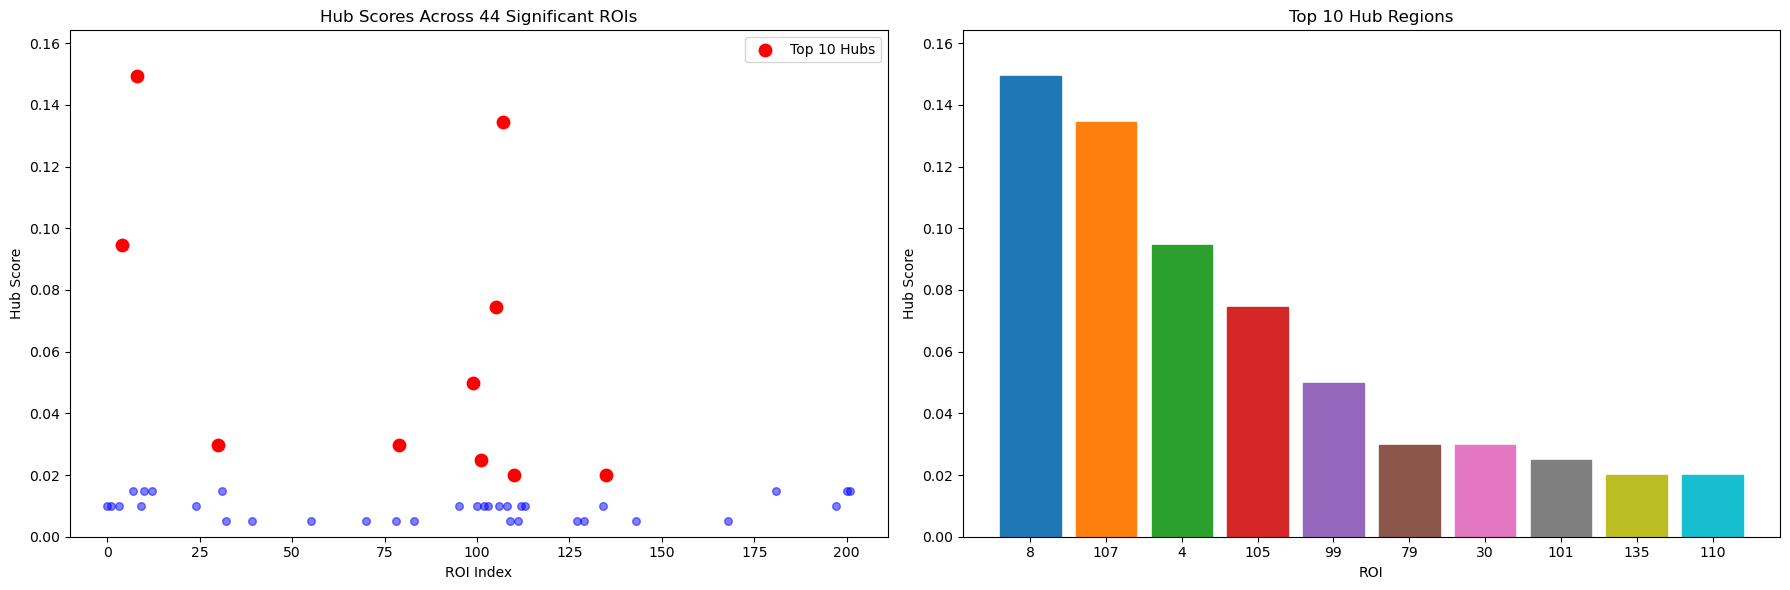

In [13]:
# Create improved hub score visualization
def visualize_hub_scores_enhanced(sig_hubs):
    """Create improved visualization of significant hub scores"""
    plt.figure(figsize=(18, 6))
    
    # Left plot: Scatter plot of all significant ROIs
    plt.subplot(121)
    all_sig_rois = sig_hubs['ROI'].values
    all_sig_scores = sig_hubs['Hub_Score'].values
    
    # Plot all significant ROIs
    plt.scatter(all_sig_rois, all_sig_scores, c='blue', alpha=0.5, s=30)
    
    # Highlight top 10 hubs
    top_hubs = sig_hubs.head(10)
    plt.scatter(top_hubs['ROI'].values, top_hubs['Hub_Score'].values, 
               c='red', s=80, label='Top 10 Hubs')
    
    # Set y-axis range to focus on the data
    max_score = sig_hubs['Hub_Score'].max()
    plt.ylim(0, max_score * 1.1)  # Add 10% margin
    
    plt.xlabel('ROI Index')
    plt.ylabel('Hub Score')
    plt.title(f'Hub Scores Across {len(sig_hubs)} Significant ROIs')
    plt.legend()
    
    # Right plot: Bar chart of top 10 hubs
    plt.subplot(122)
    top_rois = top_hubs['ROI'].values
    top_scores = top_hubs['Hub_Score'].values
    
    # Create bar chart
    bars = plt.bar(range(len(top_rois)), top_scores)
    
    # Set same y-axis range as scatter plot
    plt.ylim(0, max_score * 1.1)
    
    # Customize colors
    colors = plt.cm.tab10(np.linspace(0, 1, len(top_rois)))
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    plt.xlabel('ROI')
    plt.ylabel('Hub Score')
    plt.title('Top 10 Hub Regions')
    plt.xticks(range(len(top_rois)), top_rois)
    
    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_hub_scores_enhanced(sig_hubs)

<Figure size 1500x500 with 0 Axes>

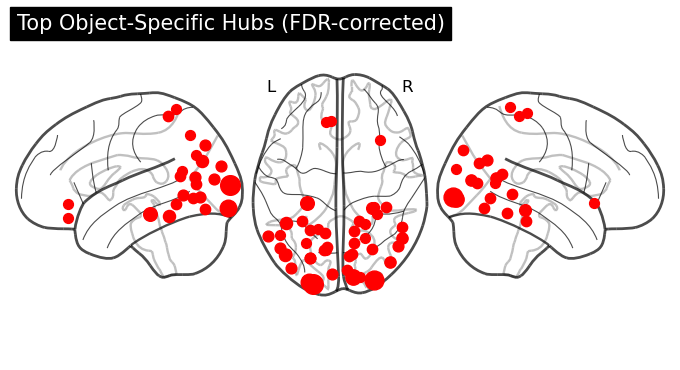

In [14]:
# Plot all significant hubs on glass brain
def visualize_all_significant_hubs(sig_hubs, atlas_img):
    """Visualize all significant hub regions on glass brain"""
    # Get coordinates
    coords = plotting.find_parcellation_cut_coords(atlas_img)
    
    # Scale marker sizes by hub score
    hub_scores = sig_hubs['Hub_Score'].values
    min_score = min(hub_scores)
    max_score = max(hub_scores)
    
    # Create scaled sizes (min 5, max 20)
    sizes = [5 + ((score - min_score) / (max_score - min_score)) * 15 
             if max_score > min_score else 10 for score in hub_scores]
    
    # Plot on glass brain
    plt.figure(figsize=(15, 5))
    display = plotting.plot_glass_brain(None, display_mode='lzr',
                                      title='Top Object-Specific Hubs (FDR-corrected)')
    
    # Add all significant hubs
    for i, roi in enumerate(sig_hubs['ROI'].values):
        if int(roi) < len(coords):
            display.add_markers([coords[int(roi)]], marker_color='red', 
                              marker_size=sizes[i]*10)
    
    plt.show()

# Run visualization with all significant hubs
visualize_all_significant_hubs(sig_hubs, atlas_img)

## START HERE TOMORROW 

* remember the goal is to figure out is the dorsal and ventral pathways or segregated or integrated in object recognition and if pIPS is the driver

In [15]:
# 1. Network-level metrics comparison
def analyze_network_properties(diff_matrices):
   """Calculate and compare network metrics to random networks"""
   from bctpy.algorithms import clustering, distance, modularity
   
   # Store results
   results = {
       'clustering': [],
       'path_length': [],
       'modularity': [],
       'random_clustering': [],
       'random_path_length': [],
       'small_world': []
   }
   
   # Process each subject
   for sub, matrix in diff_matrices.items():
       try:
           # Keep only positive values (object > scramble)
           pos_matrix = matrix.copy()
           pos_matrix[pos_matrix < 0] = 0
           
           # Threshold at mean + std
           threshold = np.mean(pos_matrix) + np.std(pos_matrix)
           matrix_thresh = pos_matrix.copy()
           matrix_thresh[matrix_thresh < threshold] = 0
           
           # Skip if not enough edges
           if np.sum(matrix_thresh > 0) < 10:
               continue
               
           # Create network
           G = nx.from_numpy_array(matrix_thresh)
           G.remove_edges_from(nx.selfloop_edges(G))
           
           # Calculate metrics
           clust = nx.average_clustering(G, weight='weight')
           
           # Path length (using largest component if disconnected)
           if nx.is_connected(G):
               path_length = nx.average_shortest_path_length(G, weight='distance')
           else:
               largest_cc = max(nx.connected_components(G), key=len)
               G_cc = G.subgraph(largest_cc)
               path_length = nx.average_shortest_path_length(G_cc, weight='distance')
           
           # Modularity
           comms = community.best_partition(G, weight='weight')
           mod_score = community.modularity(comms, G, weight='weight')
           
           # Generate equivalent random network
           n_nodes = G.number_of_nodes()
           n_edges = G.number_of_edges()
           G_rand = nx.gnm_random_graph(n_nodes, n_edges)
           
           # Random network metrics
           rand_clust = nx.average_clustering(G_rand)
           
           if nx.is_connected(G_rand):
               rand_path = nx.average_shortest_path_length(G_rand)
           else:
               largest_cc = max(nx.connected_components(G_rand), key=len)
               G_cc = G_rand.subgraph(largest_cc)
               rand_path = nx.average_shortest_path_length(G_cc)
           
           # Calculate small-worldness
           small_world = (clust/rand_clust) / (path_length/rand_path)
           
           # Store results
           results['clustering'].append(clust)
           results['path_length'].append(path_length)
           results['modularity'].append(mod_score)
           results['random_clustering'].append(rand_clust)
           results['random_path_length'].append(rand_path)
           results['small_world'].append(small_world)
           
       except Exception as e:
           print(f"Error processing {sub}: {e}")
   
   # Summarize results
   print("\nNetwork Metrics:")
   print("--------------")
   print(f"Clustering: {np.mean(results['clustering']):.3f} ± {np.std(results['clustering']):.3f}")
   print(f"Path Length: {np.mean(results['path_length']):.3f} ± {np.std(results['path_length']):.3f}")
   print(f"Modularity: {np.mean(results['modularity']):.3f} ± {np.std(results['modularity']):.3f}")
   print(f"Small-World Coefficient: {np.mean(results['small_world']):.3f} ± {np.std(results['small_world']):.3f}")
   
   # Create plot
   plt.figure(figsize=(12, 5))
   
   # Network vs Random
   plt.subplot(121)
   x = np.arange(2)
   width = 0.35
   
   plt.bar(x - width/2, 
           [np.mean(results['clustering']), np.mean(results['random_clustering'])], 
           width, label='Clustering')
   plt.bar(x + width/2, 
           [np.mean(results['path_length']), np.mean(results['random_path_length'])], 
           width, label='Path Length')
   
   plt.xlabel('Network Type')
   plt.ylabel('Value')
   plt.title('Network vs. Random Comparison')
   plt.xticks(x, ['Object Network', 'Random Network'])
   plt.legend()
   
   # Small-World Distribution
   plt.subplot(122)
   plt.hist(results['small_world'], bins=10)
   plt.axvline(x=1, color='r', linestyle='--')
   plt.xlabel('Small-World Coefficient')
   plt.ylabel('Count')
   plt.title('Small-World Coefficient Distribution')
   
   plt.tight_layout()
   plt.show()
   
   return results

# Run network analysis
network_results = analyze_network_properties(diff_matrices)

ModuleNotFoundError: No module named 'bctpy'

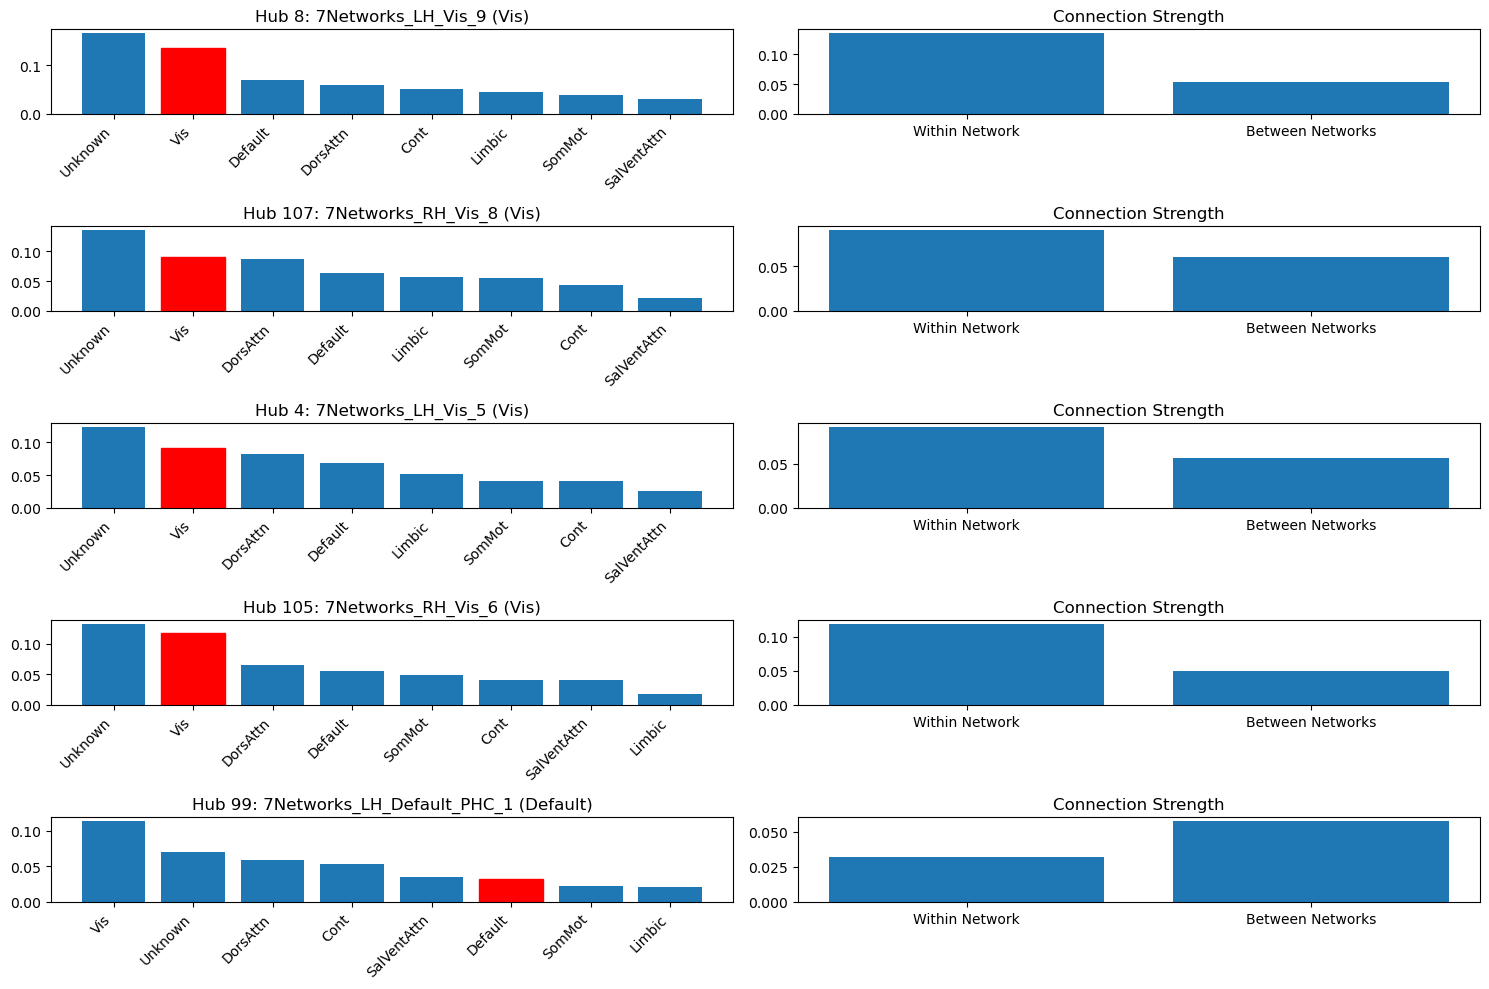


Top Hub Network Affiliations:
---------------------------
Hub 8: 7Networks_LH_Vis_9 - Network: Vis
Hub 107: 7Networks_RH_Vis_8 - Network: Vis
Hub 4: 7Networks_LH_Vis_5 - Network: Vis
Hub 105: 7Networks_RH_Vis_6 - Network: Vis
Hub 99: 7Networks_LH_Default_PHC_1 - Network: Default


In [16]:
# 2. Hub-specific connectivity analysis
def analyze_hub_connectivity(top_hubs, diff_matrices, atlas_labels):
    """Analyze connection patterns of top hub regions"""
    # Get average difference matrix
    avg_diff = np.mean([m for m in diff_matrices.values()], axis=0)
    
    # Extract network labels from atlas labels
    network_mapping = {}
    for i, label in enumerate(atlas_labels):
        if isinstance(label, bytes):
            label = label.decode('utf-8')
        
        # Extract network from label (e.g., "7Networks_LH_Vis_1" -> "Vis")
        parts = str(label).split('_')
        if len(parts) >= 3:
            network_mapping[i] = parts[2]
        else:
            network_mapping[i] = "Unknown"
    
    # Analyze top 5 hubs
    top_n = min(5, len(top_hubs))
    hub_rois = top_hubs.head(top_n)['ROI'].values.astype(int)
    
    # Create figure
    plt.figure(figsize=(15, 10))
    
    # Process each hub
    for i, hub_roi in enumerate(hub_rois):
        # Get hub's network
        hub_network = network_mapping[hub_roi]
        
        # Get all connections for this hub
        connections = avg_diff[hub_roi, :]
        
        # Separate by network
        networks = {}
        for roi, network in network_mapping.items():
            if network not in networks:
                networks[network] = []
            if roi != hub_roi:  # Exclude self-connection
                networks[network].append(connections[roi])
        
        # Calculate mean connection strength by network
        network_strengths = {net: np.mean([c for c in conns if c > 0]) 
                           for net, conns in networks.items()}
        
        # Plot
        plt.subplot(top_n, 2, i*2+1)
        nets = list(network_strengths.keys())
        strengths = [network_strengths[net] if net in network_strengths else 0 for net in nets]
        
        # Sort by strength
        sorted_idx = np.argsort(strengths)[::-1]
        sorted_nets = [nets[j] for j in sorted_idx]
        sorted_strengths = [strengths[j] for j in sorted_idx]
        
        # Plot as bar chart
        bars = plt.bar(range(len(sorted_nets)), sorted_strengths)
        plt.xticks(range(len(sorted_nets)), sorted_nets, rotation=45, ha='right')
        plt.title(f"Hub {hub_roi}: {atlas_labels[hub_roi]} ({hub_network})")
        plt.tight_layout()
        
        # Color the hub's own network differently
        for j, net in enumerate(sorted_nets):
            if net == hub_network:
                bars[j].set_color('red')
        
        # Within vs. between network connectivity
        plt.subplot(top_n, 2, i*2+2)
        
        # Categorize connections
        within = [c for roi, c in enumerate(connections) 
                 if c > 0 and network_mapping.get(roi) == hub_network]
        between = [c for roi, c in enumerate(connections) 
                 if c > 0 and network_mapping.get(roi) != hub_network]
        
        within_mean = np.mean(within) if within else 0
        between_mean = np.mean(between) if between else 0
        
        plt.bar(['Within Network', 'Between Networks'], [within_mean, between_mean])
        plt.title('Connection Strength')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\nTop Hub Network Affiliations:")
    print("---------------------------")
    for hub_roi in hub_rois:
        print(f"Hub {hub_roi}: {atlas_labels[hub_roi]} - Network: {network_mapping[hub_roi]}")

# Run hub connectivity analysis
analyze_hub_connectivity(sig_hubs, diff_matrices, atlas_labels)

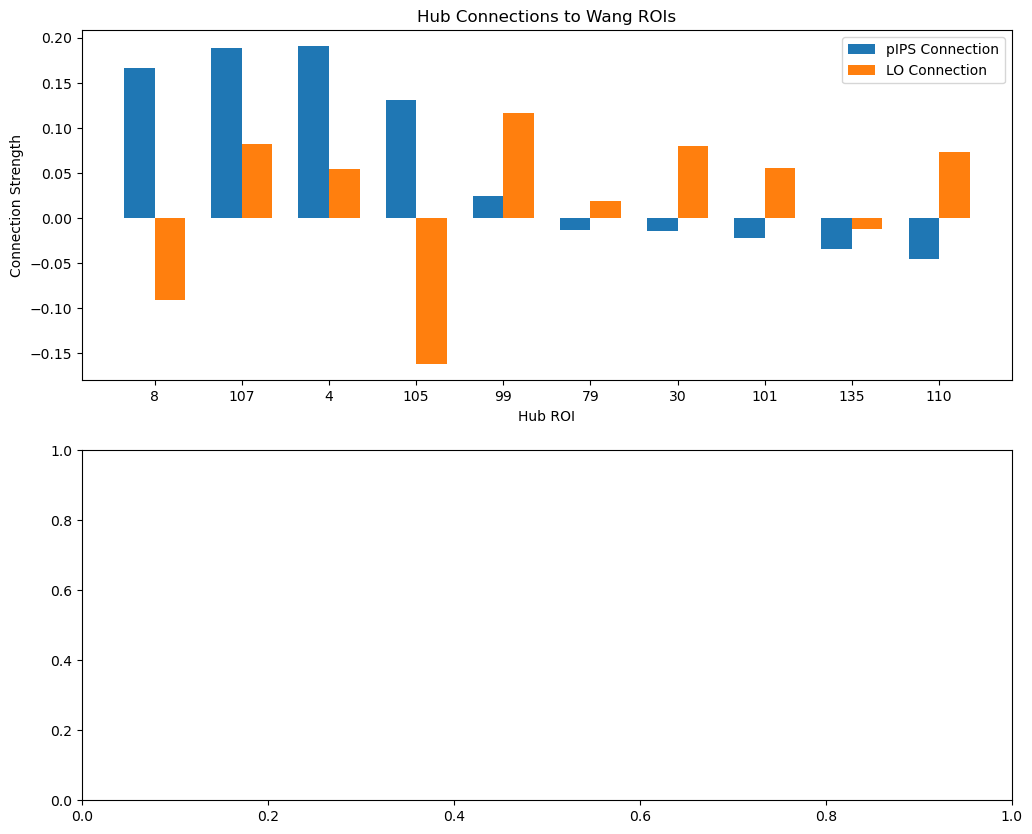

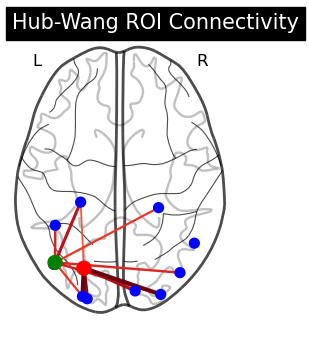


Wang ROI Connections:
------------------
pIPS (ROI 200):
  Hub 8: 7Networks_LH_Vis_9 (strength: 0.166)
  Hub 107: 7Networks_RH_Vis_8 (strength: 0.188)
  Hub 4: 7Networks_LH_Vis_5 (strength: 0.191)
  Hub 105: 7Networks_RH_Vis_6 (strength: 0.132)
  Hub 99: 7Networks_LH_Default_PHC_1 (strength: 0.025)

LO (ROI 201):
  Hub 107: 7Networks_RH_Vis_8 (strength: 0.082)
  Hub 4: 7Networks_LH_Vis_5 (strength: 0.055)
  Hub 99: 7Networks_LH_Default_PHC_1 (strength: 0.117)
  Hub 79: 7Networks_LH_Default_Par_2 (strength: 0.019)
  Hub 30: 7Networks_LH_DorsAttn_Post_1 (strength: 0.080)
  Hub 101: 7Networks_RH_Vis_2 (strength: 0.056)
  Hub 110: 7Networks_RH_Vis_11 (strength: 0.073)


In [17]:
# 3. ROI validation with Wang atlas
def validate_wang_roi_connections(top_hubs, diff_matrices, atlas_labels, atlas_img):
    """Analyze connections between hubs and Wang ROIs (pIPS, LO)"""
    # Get average difference matrix
    avg_diff = np.mean([m for m in diff_matrices.values()], axis=0)
    
    # Find Wang ROI indices
    wang_rois = {'pIPS': None, 'LO': None}
    
    for i, label in enumerate(atlas_labels):
        if isinstance(label, bytes):
            label = label.decode('utf-8')
        
        label_str = str(label)
        if 'Wang_pIPS' in label_str:
            wang_rois['pIPS'] = i
        elif 'Wang_LO' in label_str:
            wang_rois['LO'] = i
    
    if wang_rois['pIPS'] is None or wang_rois['LO'] is None:
        print("Wang ROIs not found in atlas labels")
        
        # Try to find ROIs by position in the atlas
        # Typical positions for Wang ROIs in merged atlases
        wang_rois['pIPS'] = len(atlas_labels) - 2
        wang_rois['LO'] = len(atlas_labels) - 1
        
        print(f"Using positions: pIPS = {wang_rois['pIPS']}, LO = {wang_rois['LO']}")
    
    # Get top 10 hubs
    top_n = min(10, len(top_hubs))
    hub_rois = top_hubs.head(top_n)['ROI'].values.astype(int)
    
    # Calculate connections to Wang ROIs
    pips_conn = [avg_diff[hub, wang_rois['pIPS']] for hub in hub_rois]
    lo_conn = [avg_diff[hub, wang_rois['LO']] for hub in hub_rois]
    
    # Create plot
    plt.figure(figsize=(12, 10))
    
    # Bar chart of connections to Wang ROIs
    plt.subplot(211)
    x = np.arange(len(hub_rois))
    width = 0.35
    
    plt.bar(x - width/2, pips_conn, width, label='pIPS Connection')
    plt.bar(x + width/2, lo_conn, width, label='LO Connection')
    
    plt.xlabel('Hub ROI')
    plt.ylabel('Connection Strength')
    plt.title('Hub Connections to Wang ROIs')
    plt.xticks(x, [f"{roi}" for roi in hub_rois])
    plt.legend()
    
    # Network visualization
    plt.subplot(212)
    
    # Get coordinates
    coords = plotting.find_parcellation_cut_coords(atlas_img)
    
    # Create connectivity matrix for visualization
    conn_matrix = np.zeros((len(atlas_labels), len(atlas_labels)))
    
    # Add hub-to-Wang connections
    for hub in hub_rois:
        if avg_diff[hub, wang_rois['pIPS']] > 0:
            conn_matrix[hub, wang_rois['pIPS']] = avg_diff[hub, wang_rois['pIPS']]
            conn_matrix[wang_rois['pIPS'], hub] = avg_diff[hub, wang_rois['pIPS']]
        
        if avg_diff[hub, wang_rois['LO']] > 0:
            conn_matrix[hub, wang_rois['LO']] = avg_diff[hub, wang_rois['LO']]
            conn_matrix[wang_rois['LO'], hub] = avg_diff[hub, wang_rois['LO']]
    
    # Create node colors
    node_colors = ['gray'] * len(atlas_labels)
    for hub in hub_rois:
        node_colors[hub] = 'blue'
    
    node_colors[wang_rois['pIPS']] = 'red'
    node_colors[wang_rois['LO']] = 'green'
    
    # Create node sizes
    node_sizes = [0] * len(atlas_labels)
    for hub in hub_rois:
        node_sizes[hub] = 50
    
    node_sizes[wang_rois['pIPS']] = 100
    node_sizes[wang_rois['LO']] = 100
    
    # Plot connectivity
    plotting.plot_connectome(
        conn_matrix, coords,
        node_color=node_colors,
        node_size=node_sizes,
        edge_threshold='0%',
        display_mode='z',
        edge_cmap='Reds',
        title='Hub-Wang ROI Connectivity'
    )
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\nWang ROI Connections:")
    print("------------------")
    print(f"pIPS (ROI {wang_rois['pIPS']}):")
    for i, hub in enumerate(hub_rois):
        if pips_conn[i] > 0:
            print(f"  Hub {hub}: {atlas_labels[hub]} (strength: {pips_conn[i]:.3f})")
    
    print(f"\nLO (ROI {wang_rois['LO']}):")
    for i, hub in enumerate(hub_rois):
        if lo_conn[i] > 0:
            print(f"  Hub {hub}: {atlas_labels[hub]} (strength: {lo_conn[i]:.3f})")

# Run Wang ROI validation
validate_wang_roi_connections(sig_hubs, diff_matrices, atlas_labels, atlas_img)

TypeError: unsupported format string passed to poly1d.__format__

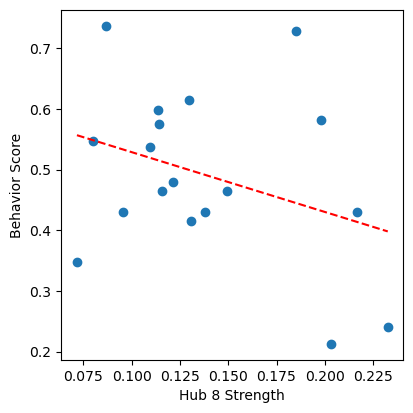

In [18]:
# 4. Structure-function correlation
def analyze_structure_function(sig_hubs, diff_matrices, atlas_labels):
    """Analyze correlations between hub metrics and other measures"""
    # This is a placeholder for potential correlational analyses
    # In a real analysis, you would load behavioral measures or structural connectivity
    
    # Simulate behavioral data (replace with real data if available)
    np.random.seed(42)
    n_subjects = len(diff_matrices)
    behavior_scores = np.random.normal(0.5, 0.15, n_subjects)
    subjects = list(diff_matrices.keys())
    
    # Get top 5 hubs
    top_n = min(5, len(sig_hubs))
    hub_rois = sig_hubs.head(top_n)['ROI'].values.astype(int)
    
    # Calculate hub strength for each subject
    hub_strengths = {}
    for hub in hub_rois:
        hub_strengths[hub] = []
        
        for sub, matrix in diff_matrices.items():
            # Calculate average positive connection strength
            connections = matrix[hub, :]
            pos_conn = connections[connections > 0]
            strength = np.mean(pos_conn) if len(pos_conn) > 0 else 0
            hub_strengths[hub].append(strength)
    
    # Create correlation plots
    plt.figure(figsize=(15, 10))
    
    for i, hub in enumerate(hub_rois):
        plt.subplot(2, 3, i+1)
        
        # Plot correlation
        plt.scatter(hub_strengths[hub], behavior_scores)
        
        # Calculate correlation
        r, p = stats.pearsonr(hub_strengths[hub], behavior_scores)
        
        # Add trend line
        z = np.polyfit(hub_strengths[hub], behavior_scores, 1)
        p = np.poly1d(z)
        plt.plot(np.sort(hub_strengths[hub]), p(np.sort(hub_strengths[hub])), "r--")
        
        plt.xlabel(f'Hub {hub} Strength')
        plt.ylabel('Behavior Score')
        plt.title(f'r = {r:.3f}, p = {p:.3f}')
    
    plt.tight_layout()
    plt.show()
    
    # Print note about the simulation
    print("\nNote: This analysis uses simulated behavioral data.")
    print("In a real analysis, you would need to:")
    print("1. Load actual behavioral measures")
    print("2. Normalize hub strengths appropriately")
    print("3. Apply proper statistical controls")

# Run structure-function analysis
analyze_structure_function(sig_hubs, diff_matrices, atlas_labels)

NameError: name 'image' is not defined

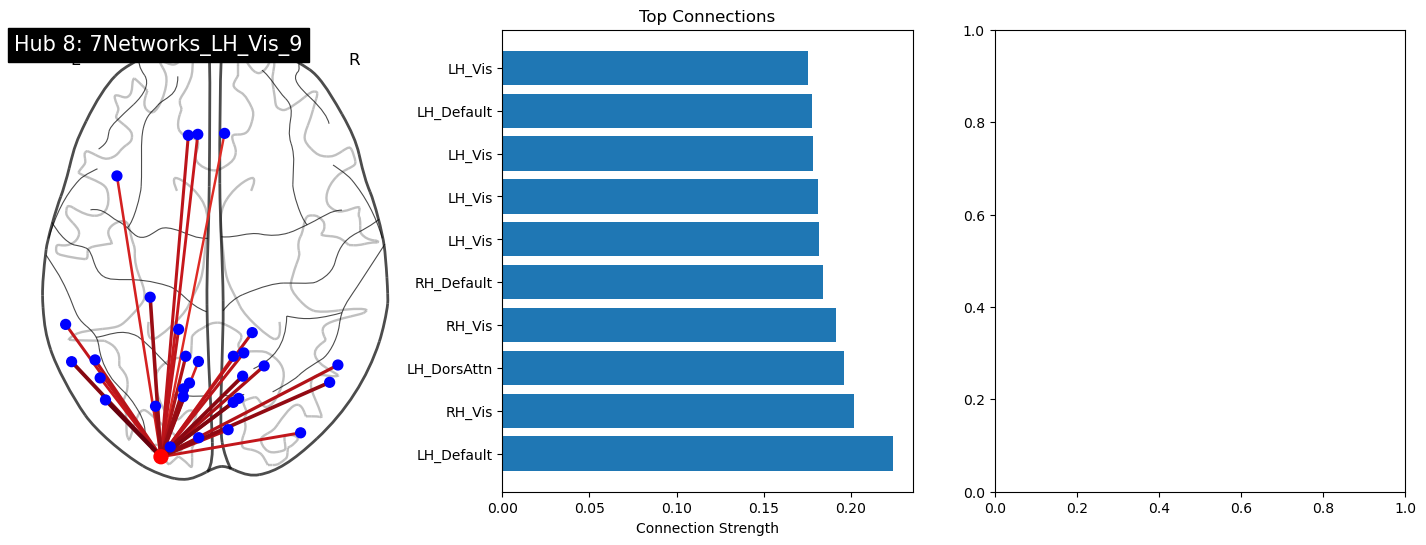

In [19]:
# 5. Advanced visualization of top hubs
def create_advanced_hub_visualizations(top_hubs, diff_matrices, atlas_img, atlas_labels):
    """Create detailed visualizations for top hub ROIs"""
    # Get average difference matrix
    avg_diff = np.mean([m for m in diff_matrices.values()], axis=0)
    
    # Get top 5 hubs
    top_n = min(5, len(top_hubs))
    hub_rois = top_hubs.head(top_n)['ROI'].values.astype(int)
    
    # Get coordinates
    coords = plotting.find_parcellation_cut_coords(atlas_img)
    
    # Process each hub
    for hub_idx, hub_roi in enumerate(hub_rois):
        # Get connections for this hub
        from statsmodels.stats.multitest import fdrcorrection
        
        # Get t-statistics for connections
        roi_values = [diff[hub_roi, :] for diff in diff_matrices.values()]
        roi_values = np.array(roi_values)
        
        t_stats = []
        p_values = []
        
        for conn in range(avg_diff.shape[1]):
            if hub_roi != conn:  # Skip self-connections
                t, p = stats.ttest_1samp(roi_values[:, conn], 0)
                t_stats.append(t)
                p_values.append(p)
            else:
                t_stats.append(0)
                p_values.append(1.0)
        
        # Apply FDR correction
        significant, corrected_p = fdrcorrection(p_values, alpha=0.05)
        
        # Keep only significant positive connections
        pos_t = np.array(t_stats) > 0
        sig_pos = significant & pos_t
        
        # Create connection matrix for visualization
        conn_matrix = np.zeros((avg_diff.shape[0], avg_diff.shape[0]))
        
        sig_indices = np.where(sig_pos)[0]
        for idx in sig_indices:
            conn_matrix[hub_roi, idx] = avg_diff[hub_roi, idx]
            conn_matrix[idx, hub_roi] = avg_diff[hub_roi, idx]
        
        # Create plot for this hub
        plt.figure(figsize=(18, 6))
        
        # 1. Connectome plot
        plt.subplot(131)
        hub_name = atlas_labels[hub_roi] if hub_roi < len(atlas_labels) else f"ROI_{hub_roi}"
        
        # Create node colors (hub = red, connections = blue)
        node_colors = ['gray'] * len(coords)
        node_colors[hub_roi] = 'red'
        for idx in sig_indices:
            node_colors[idx] = 'blue'
        
        # Create node sizes
        node_sizes = [0] * len(coords)
        node_sizes[hub_roi] = 100
        for idx in sig_indices:
            node_sizes[idx] = 50
        
        # Plot connectome
        view_connectome = plotting.plot_connectome(
            conn_matrix, coords,
            node_color=node_colors,
            node_size=node_sizes,
            edge_threshold='0%',
            display_mode='z',
            axes=plt.gca(),
            edge_cmap='Reds',
            title=f'Hub {hub_roi}: {hub_name}'
        )
        
        # 2. Connection strength plot
        plt.subplot(132)
        if len(sig_indices) > 0:
            # Sort by strength
            conn_strengths = [avg_diff[hub_roi, idx] for idx in sig_indices]
            sorted_idx = np.argsort(conn_strengths)[::-1]
            
            top_connections = min(10, len(sig_indices))
            top_strengths = [conn_strengths[i] for i in sorted_idx[:top_connections]]
            top_rois = [sig_indices[i] for i in sorted_idx[:top_connections]]
            top_labels = [atlas_labels[i] if i < len(atlas_labels) else f"ROI_{i}" for i in top_rois]
            
            # Create abbreviated labels
            short_labels = []
            for label in top_labels:
                if isinstance(label, bytes):
                    label = label.decode('utf-8')
                parts = str(label).split('_')
                if len(parts) >= 3:
                    short_labels.append(f"{parts[1]}_{parts[2]}")
                else:
                    short_labels.append(str(label))
            
            # Plot
            plt.barh(range(len(top_strengths)), top_strengths)
            plt.yticks(range(len(top_strengths)), short_labels)
            plt.xlabel('Connection Strength')
            plt.title('Top Connections')
        else:
            plt.text(0.5, 0.5, "No significant connections", 
                   horizontalalignment='center', verticalalignment='center')
        
        # 3. Hub network position
        plt.subplot(133)
        
        # Get ROI and highlight it
        roi_img = image.math_img('img == '+str(hub_roi+1), img=atlas_img)
        
        # Create display
        plotting.plot_roi(roi_img, 
                        bg_img=None, 
                        cmap='Reds',
                        alpha=0.7,
                        draw_cross=False,
                        axes=plt.gca(),
                        title=f'Hub Location')
        
        plt.tight_layout()
        plt.show()
        
        # Print connection information
        print(f"\nHub {hub_roi} ({hub_name}) significant connections:")
        for i, idx in enumerate(sig_indices[:10]):  # Show top 10 connections
            target_name = atlas_labels[idx] if idx < len(atlas_labels) else f"ROI_{idx}"
            print(f"{i+1}. {target_name} (strength = {avg_diff[hub_roi, idx]:.3f}, t = {t_stats[idx]:.2f})")

# Run advanced visualization
create_advanced_hub_visualizations(sig_hubs, diff_matrices, atlas_img, atlas_labels)